# Teledetección para el estudio del Acqua Alta, Turbidez y temperatura de Venecia

En este proyecto se aplicarán técnicas de procesamiento de imágenes de satélites con el objetivo de estudiar distintos aspectos:
- Acqua Alta: Es un tipo de inundación periódica que experimenta Venecia debido a la subida excepcional de la marea. Es un serio problema que experimenta Venecia y es de especial de interés de estudio
- La turbidez del agua: Estudiando la medida de claridad del agua debido a partículas en suspensión(sedimento, materia orgánica o microorganismos)
- La temperatura.
Para estudiarlos, se querrán obtener los siguientes resultados:
- Un mapa donde se muestre las inundaciones
- Un mapa donde se muestre la turbidez en el agua
- Un mapa de temperatura.

# Parte 1 Acqua alta

En este apartado se  van aplicar distintas técnicas a la imágenes para obtener información sobre las inundaciones. 

## Paso 1, Visualización de las imágenes

En este paso se van a descargar las imágenes, se van a visualizar y se les va ajustar el brillo para poder trabajar con ellas.

In [700]:
# Se importan las librerías necesarias para el trabajo
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import getpass
from pathlib import Path
from typing import Any, Optional, Tuple
import cv2 as cv
import math

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)
config = SHConfig('Teledeteccion') 

A continuación se presenta el código necesario para acceder a las imágenes del satélite 

In [701]:
# coordenadas de Venecia
aoi_coords_wgs84 = aoi_coords_wgs84 = [12.27, 45.395, 12.39, 45.485] # Indicamos las coordenadas de longitudes y latitudes de las esquinas de la zona
resolution = 10                                            # Resolución en metros
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84) # Se crea el BBOX para formalizar las coordenadas
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution) # Cálculo del tamaño de la caja

Se quieren dos tipos de imágenes:
- Imagen *rgb*, las bandas son ("B02", "B03", "B04")
- Imagen *falso color*, donde la banda roja (B02) se sustituye por la banda NIR (Infrarojo cercano) (B08)  

In [ ]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3,
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""


evalscript_false_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B08", "B04", "B03"]
            }],
            output: {
                bands: 3,
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B08, sample.B04, sample.B03];
    }
    
"""

A continuación se crea una función que permite devolver ambos tipos de imágenes para un intervalo de fecha (fecha1, fecha2) indicado

In [703]:
def devuelve_imagen(fechas):
    # Se indica que se quieren acceder a imagenes de sentinel 2 L2A
    request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                # Nombre del satélite y url de copernucus
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            # Intervalo de fechas
            time_interval= fechas,
            # se quiere con la menor cantidad de cobertura de nubes posibles
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,)
    
    request_false_color = SentinelHubRequest(
    evalscript=evalscript_false_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=fechas,
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,)
    true_color_imgs = request_true_color.get_data()
    false_color_imgs = request_false_color.get_data()
    res1 = true_color_imgs[0]
    res2 = false_color_imgs[0]
    return res1,res2

Se quiere estudiar la evolución de forma mensual durante el año de 2019 (más inundaciones), por ello pillamos imágenes de cada mes (excepto mayo, porque sale nublada y afecta al índice).
En el siguiente código se obtienen las imágenes para la fecha indicada.

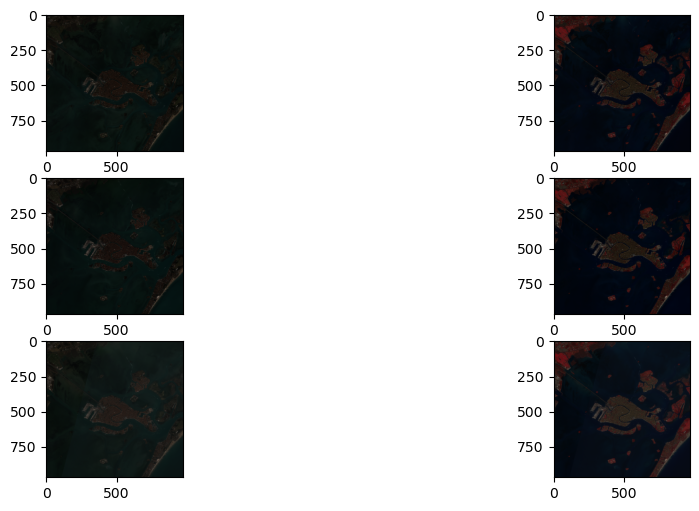

In [704]:

fechas = [('2019-01-01', '2019-01-27'),('2019-02-01', '2019-02-27'),('2019-03-01', '2019-03-27'),('2019-04-01', '2019-04-27'),('2019-06-01', '2019-06-27'),
 ('2019-07-01', '2019-07-27'),('2019-08-01', '2019-08-27'),('2019-09-01', '2019-09-27'),('2019-10-01', '2019-10-27'),('2019-11-01', '2019-11-27'),
 ('2019-12-01', '2019-12-27')]
ls_meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
def obten_imágenes(ds):
    ls_tc = []
    ls_fc = []
    for d in ds:
        im1, im2=devuelve_imagen(d)
        ls_tc.append(im1)
        ls_fc.append(im2)
    return ls_tc, ls_fc
# Se muestran las 3 primeras imágenes 
ls_tc, ls_fc= obten_imágenes(fechas)
fig, axs = plt.subplots(3, 2,figsize=(12,6))
axs[0,0].imshow(ls_tc[0])
axs[0,1].imshow(ls_fc[0])
axs[1,0].imshow(ls_tc[1])
axs[1,1].imshow(ls_fc[1])
axs[2,0].imshow(ls_tc[2])
axs[2,1].imshow(ls_fc[2])

Se observan que las imágenes salen muy oscuras, esto supondrá un problema para los siguientes pasos a realizar.
Para solucionarlo se va aplicar **Expansión con corte de cola** para aumentarle el brillo a la imagen.

Función histograma, obtiene un hidrograma (recuento) de los niveles de pixeles necesarios para las siguientes funciones.

In [705]:
def histograma(img):
    # Convierte en array de numpy
    np_image = np.array(img)
    # El eje x será los valores de los pixeles, el eje y será el conteo
    # se saca con np.unique
    x, y = np.unique(np_image, return_counts = True)
    #plt.bar(x,y)
    #plt.xlabel("Intensidades de pixeles")
    #plt.ylabel("Conteo")
    # devolvemos los distintos valores de pixeles y el contador
    return x,y

Aplicamos expansión lineal a la imagen, mapeandola (desplazandola) en un rango de valores en concreto

In [706]:
def expan(img,cmin,cmax):
    resimg = img.copy()
    np_array = np.array(resimg)
    mask1 = np_array <=cmin
    mask2 = np_array >=cmax
    mask3 = ~(mask1 | mask2)
    np_array[mask1] = 0.0
    np_array[mask2] = 255.0
    np_array[mask3] = 0.0 + (np_array[mask3] - cmin) * (255.0 / (cmax- cmin))
    return np_array.astype(np.uint8)

Con la siguiente función (que depende de las dos anteriores), se logra eliminar los pixeles más oscuros mejorando el contraste.

In [707]:
def corte(img,porc):
    img1 = img.copy() 
    # cálculo del histograma
    nd, frec = histograma(img1)
    total = sum(frec)
    # calculo de la proporción de pixeles que se van
    prop = int(total * porc)
    frecac = 0
    cmin = 0
    cmax = 0 
    # Recorremos las dos listas de pixeles y frecuencia 
    # calculamos la prefuencia acumulada 
    # el primer pixel cuya frecuencia acumulada revase a prop
    for i,j in zip(nd,frec):
        frecac += j
        if frecac > prop :
            cmin = i 
            break
    # lo mismo para cmax pero revertemos la lista
    frecac = 0
    for i,j in list(zip(nd,frec))[::-1]:
        frecac += j
        if frecac > prop :
            cmax = i 
            break
    return expan(img1,cmin,cmax)

Se aplica la función a las imágenes del satélite y se almacenan las imágenes resultantes.

Imágenes tras aplicar expansión


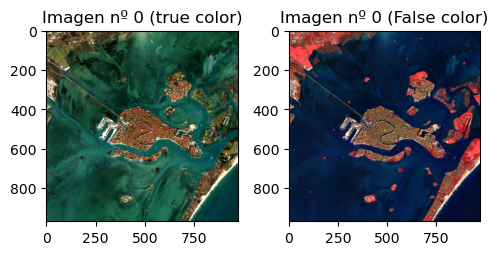

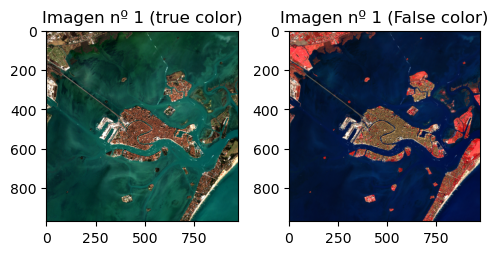

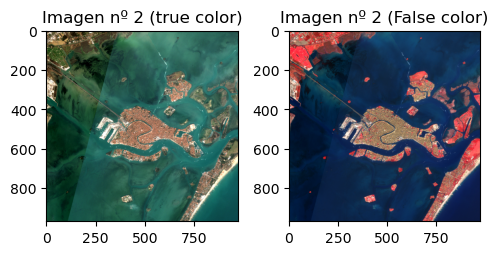

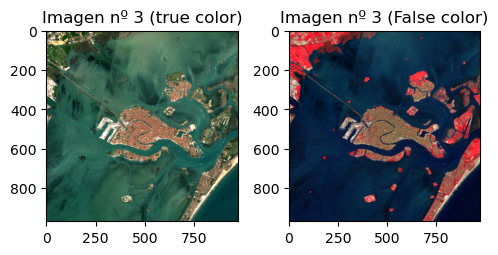

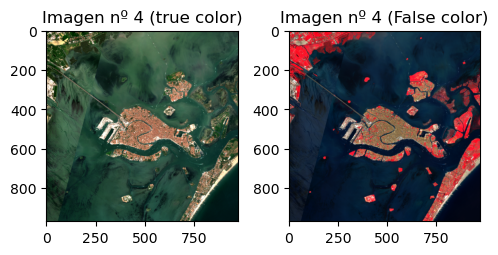

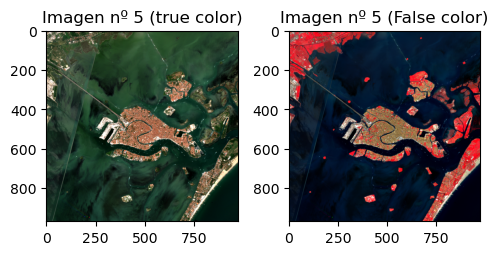

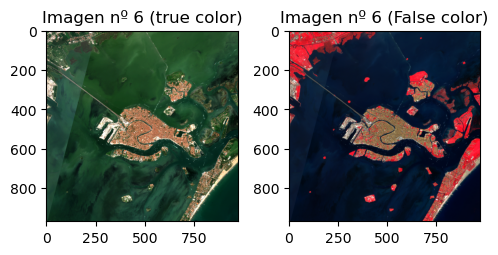

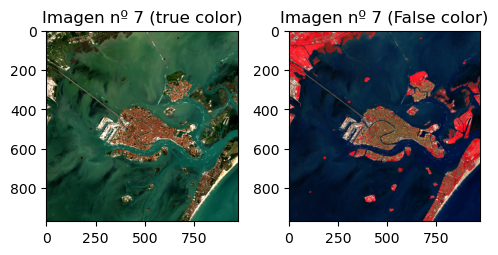

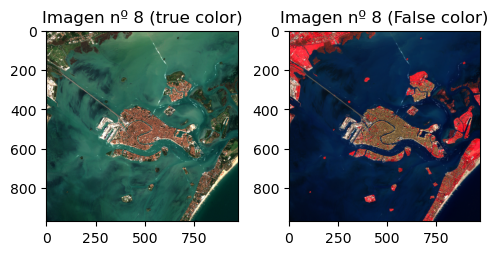

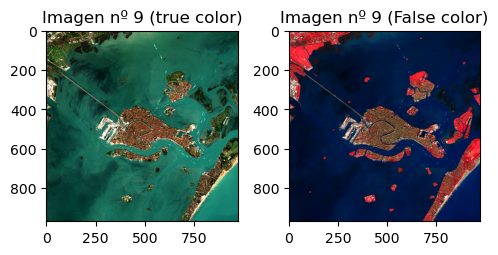

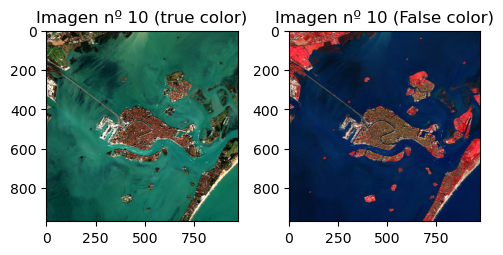

In [765]:
#Lista para las imágenes rgb
ls_tc_2 =[]
#Lista para las imágenes a falso color
ls_fc_2 =[]
print("Imágenes tras aplicar expansión")
for ind,(i_t, i_f) in enumerate(zip(ls_tc, ls_fc)):
    # le aplicamos un porcentaje de pixeles del 1%
    i_t_c = corte(i_t,0.01)
    # se añade a la lista
    ls_tc_2.append(i_t_c)
    i_f_c = corte(i_f,0.01)
    # se almacena a la lisat
    ls_fc_2.append(i_f_c)
    # Visualizamos las imágenes
    fig,ax = plt.subplots(1,2, figsize=(5, 6))
    ax[0].imshow(i_t_c)
    ax[0].set_title(f'Imagen nº {ind} (true color)')
    ax[1].imshow(i_f_c)
    ax[1].set_title(f'Imagen nº {ind} (False color)')
    # Para evitar solapamiento de los títulos
    plt.tight_layout()
    plt.show()

### Paso 2, Cálculo del Índice De Agua De Diferencia Normalizada (NDWI)

Con el índice de agua de diferencia normalizada (NDWI) se reduce la reflectancia del suelo y de la vegetación lo que permite que se resalten las masas de agua, se usa hoy en día para detectar los cambios leves en las masas de agua (es lo que se quiere estudiar).
Este índice aprovecha la banda verde y la banda NIR, realizando el siguiente cálculo:
$$\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}$$

A continuación se define una función que calcula el NDWI para las imágenes de Sentinel-2, con el siguiente cálculo:
$$\text{NDWI} = \frac{\text{Band 3} - \text{Band 8}}{\text{Band 3} + \text{Band 8}}$$

Este valor queda típicamente entre valores de -1 y 1, se aplica un reesacalado a un rango de valores de 0 a 255 para poder visualizar la imagen.

In [709]:
def ndwi(img_falsa,img_verdad):
     # Se le pasan dos imágenes, la imagen a verdadero color y a falso color
    # Extraemos la banda infrarojo, la tercera banda, que es el primer canal  
    imnir = img_falsa[:,:,0].astype(np.float64)
    # Extraemos la banda  verde,  B03
    imverd = img_verdad[:,:,1].astype(np.float64)
    # Creamos una nueva imagen con valor iniciado -1, para darle luego un valor de 0 en el rescalado a la imagen donde el 
    # divisor sea 0, para las zonas donde no hay agua
    img_res = np.full_like(imverd, -1)
    # Calculo del numerador
    numer = imverd- imnir
    denom = imverd + imnir
    # cuanod el denominador sea distinto de 0, para eviatar probelemas con la división
    filtro = denom != 0 
    img_res[filtro] = numer[filtro] / denom[filtro]
    # rescalado de la imagen 
    nvi = ((img_res +1)/2) *255
    return nvi.astype(np.uint8)

A continuación se muestran las imágenes con el NDWI aplicado, se puede observar lo siguiente:
- Las zonas donde hay agua se ven más brillantes (amarillentas o verdosas)
- Las zonas donde hay tierra se ven más oscuras (tirando para azulado oscuro).

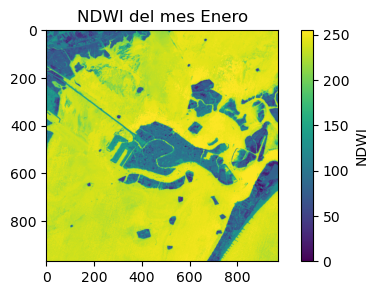

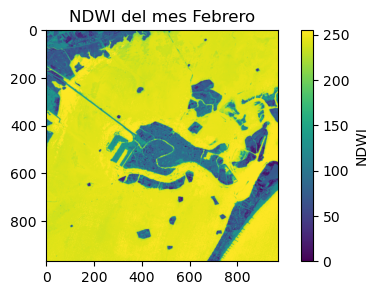

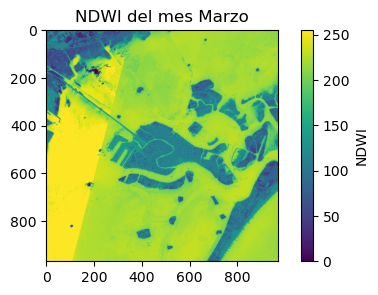

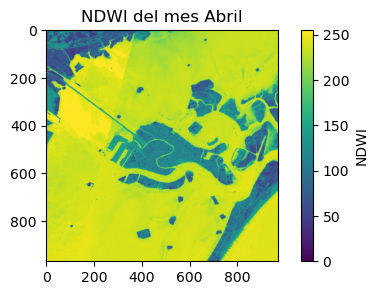

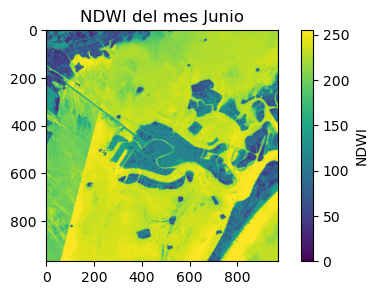

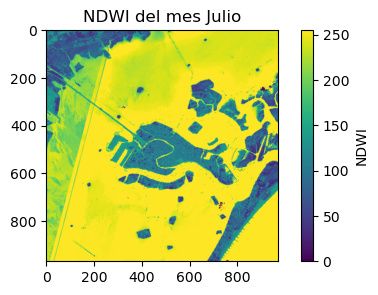

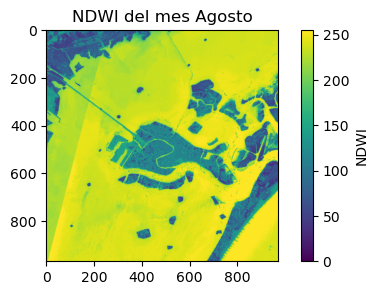

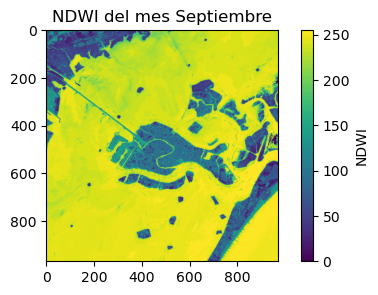

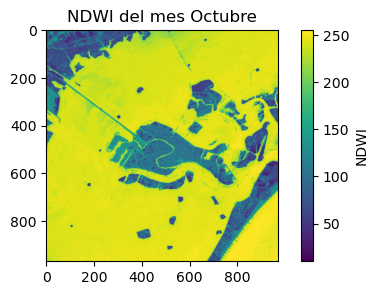

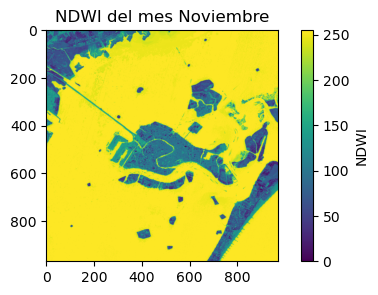

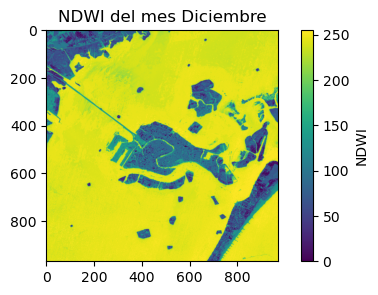

In [724]:
# La lista de imágnes NDWI
ls_ndwi =[]
cont = 0
for ind,(i_t, i_f) in zip(ls_meses,zip(ls_tc_2, ls_fc_2)):
    #se calcula para cadda imageb
    i_ndwi = ndwi(i_f,i_t)
    # se almacena
    ls_ndwi.append(i_ndwi)
    # se visualiza
    fig,ax = plt.subplots(1,1,figsize=(6, 3))
    im = ax.imshow(i_ndwi)
    plt.colorbar(im, ax=ax, label='NDWI')
    ax.set_title(f'NDWI del mes {ind}')


## Paso 3, Segmentación

A continuación se va a segmentar la imagen mediante **Density Slicing**, que permite tomar la imagen del NDWI y dividirla en valores de 
pixeles dependiendo de un umbral.
En este caso se usaran dos colores, azul para el agua y gris para la tierra, y se separaran según umbral de valor de pixel que en este caso es 160 (derivado de las imágenes anteriores y de pruebas realizadas).
Los pixeles menores que 160 simbolizarán la tierra (gris) y los superiores a este el agua (azul).

In [711]:
def densi(img,umbral, color1, color2):
    res = np.zeros((img.shape[0],img.shape[1],3)).astype(np.uint8) # almacen de resultados
    res[img < umbral ] = color1 # pixeles "tierra"
    res[img >= umbral] = color2 # pixeles "agua"
    return res

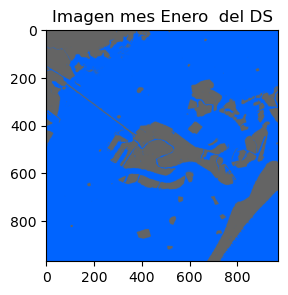

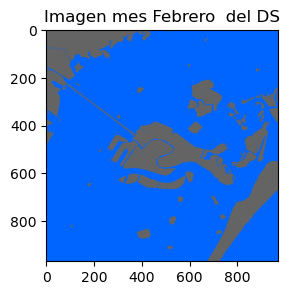

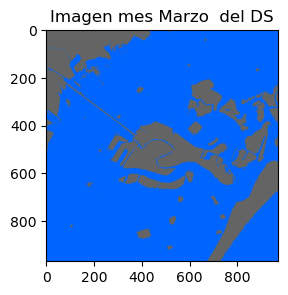

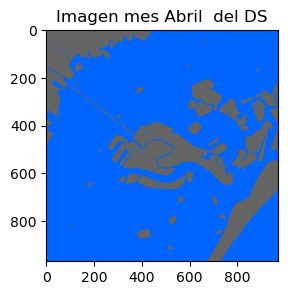

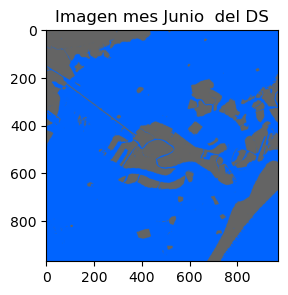

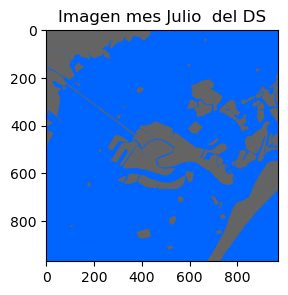

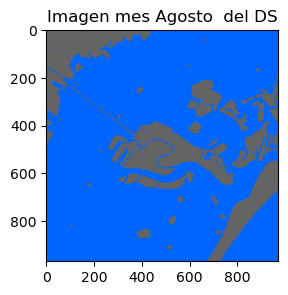

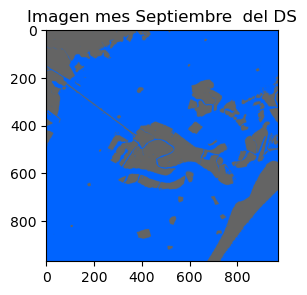

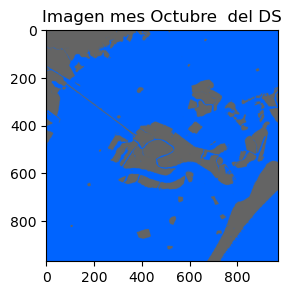

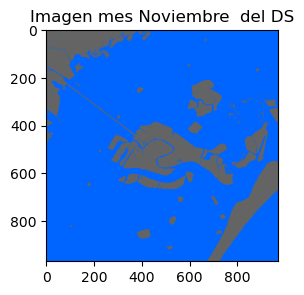

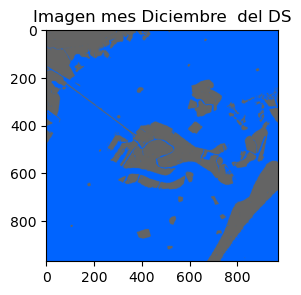

In [726]:
color_agua = [0,100,255] #Color gris
color_no_agua = [100,100,100] # color azul
umbral = 160
ls_densi =[]
cont = 0
# se aplica para cada imagen NDwI, se almacena y se visualiza
for ind,img in zip(ls_meses,ls_ndwi):
    
    i_densi = densi(img, umbral,color_no_agua, color_agua)
    ls_densi.append(i_densi)
    fig,ax = plt.subplots(1,1, figsize=(6, 3))
    ax.imshow(i_densi)
    ax.set_title(f'Imagen mes {ind}  del DS')


## Paso 4 Mapa de inundaciones

En este apartado se crea un mapa donde se muestra la evolución de las Aqua alta, para ello:
- Se crea una función mapa diferencia que recibe las lista de imágenes resultantes del density slicing, centrandose en las zonas donde hay agua calcula la diferencia de la imagen con la anterior. Convirtiendo los pixeles a valores 0 (No ha habido cambio, agua -> agua, tierra -> tierra), 1(tierra -> Agua) o -1 (agua -> tierra).


Mediante density slicing se puede diferenciar correctamente cada uno de los casos asignándole un color:
- Aparición de inundación -> Azul
- Eliminación de inundación -> Verde
- Sin cambio -> Blanco.

In [717]:
def mapa_diferencia(ls):
    ls_mapa = []
    ls_inter = []
    # Rcorremos los indices de la imagen haasta la penultima
    for i in range(len(ls)-1):
        # Nos interesa las zonas donde hay agua en el mes 
        mapa_marea_normal = np.all(ls[i]==color_agua,axis=2).astype(np.int8)
        # Nos interesa las zonas donde hay agua en el mes sucesor
        mapa_marea_alta = np.all(ls[i+1]==color_agua,axis=2).astype(np.int8)
        # Se calcula la diferencia y se añade a la lista  de mapas
        mapa_inundacion = mapa_marea_alta - mapa_marea_normal
        mes = f"{ls_meses[i]} - {ls_meses[i+1]}"
        ls_mapa.append(mapa_inundacion)
        ls_inter.append(mes)
    # Por ultimo comparamos el primero con el ultimo , repitiendo los pasos
    mapa_marea_normal = np.all(ls[0]==color_agua,axis=2).astype(np.int8)
    mapa_marea_alta = np.all(ls[-1]==color_agua,axis=2).astype(np.int8)
    mapa_inundacion = mapa_marea_alta - mapa_marea_normal
    mes = ls_meses[0] +'-'+ ls_meses[-1]
    ls_inter.append(mes)
    ls_mapa.append(mapa_inundacion)
    return ls_mapa, ls_inter

In [718]:
#Devuelve los mapas y los intervalos de meses
ls_maps_inund, ls_meses_inter = mapa_diferencia(ls_densi)

In [719]:
def densi2(img,colores):
    res = np.zeros((img.shape[0],img.shape[1],3)).astype(np.uint8)
    # donde se ha -1 quitado la inundación
    res[img == -1 ] = colores[0]
    # se mantiene constante
    res[img == 0] = colores[1]
    # 1 ha aparecido una indación
    res[img == 1] = colores[2]
    return res

Se iteran las imágenes de los mapas DS (density slicing) para mostrar los resultados al aplicar la resta.

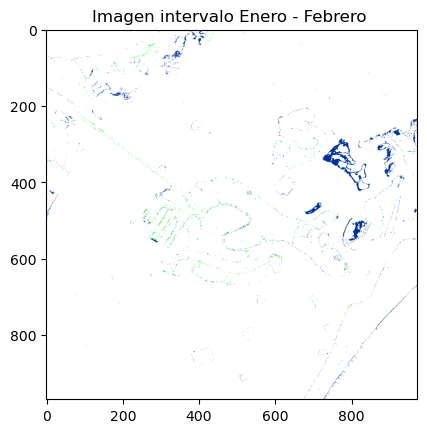

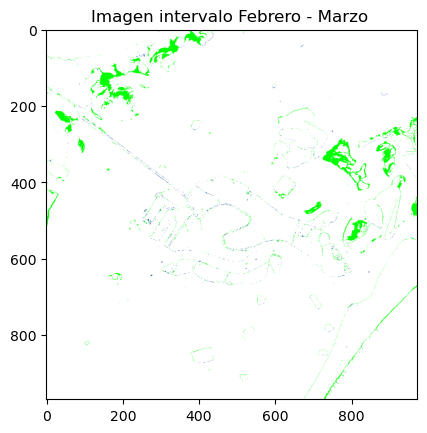

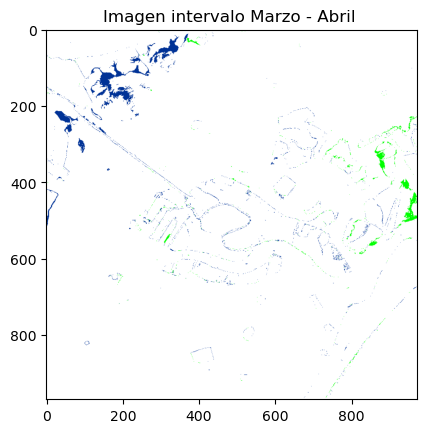

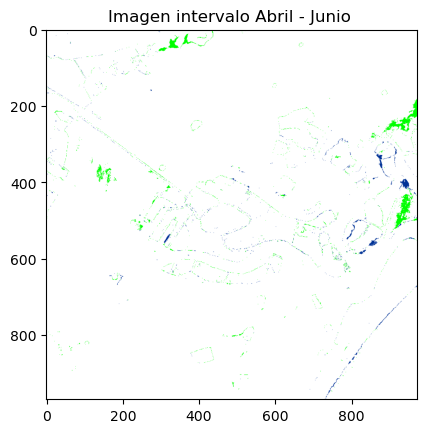

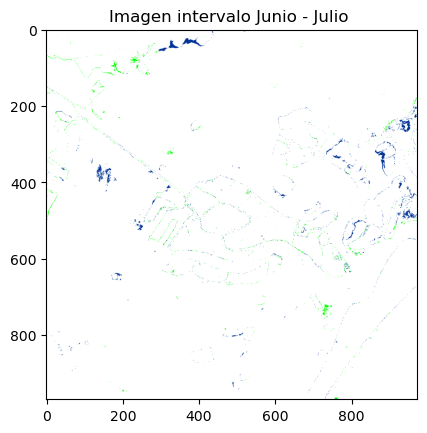

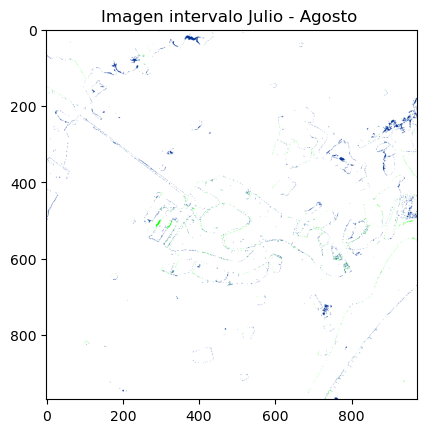

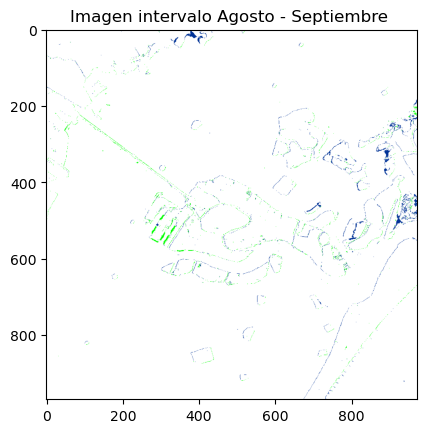

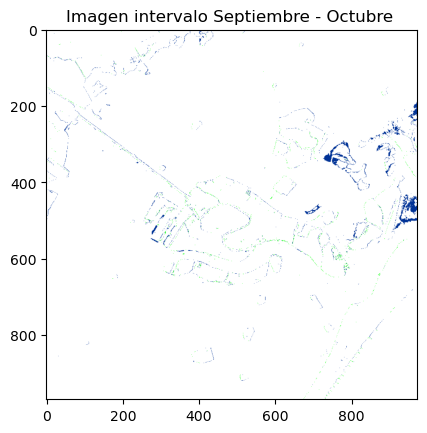

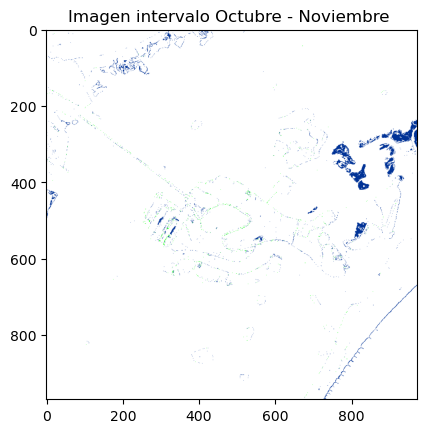

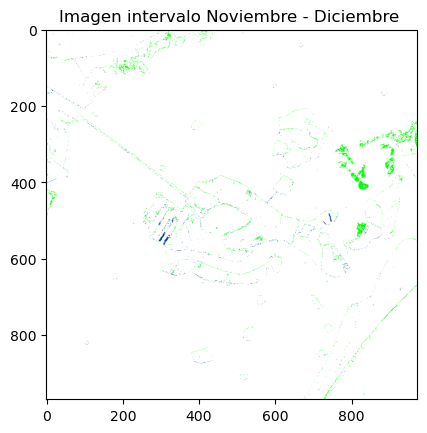

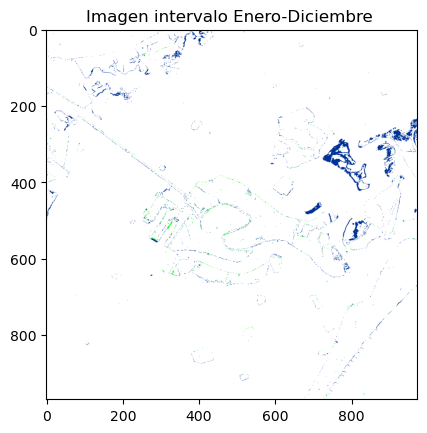

In [721]:
colores = [[0, 255, 0], # Se ha retirado el agua en azul
           [255,255, 255], # se Ha mantenido
           [0, 50, 150] # Innundación en naranja 
          ]
import imageio.v3 as iio
ls_densi2DS = []
ls_gif = []
for (img,ind) in zip(ls_maps_inund,ls_meses_inter):
    i_densi2 = densi2(img,colores)
    ls_densi2DS.append(i_densi2)
    fig,ax = plt.subplots(1,1)#,figsize=(12, 6))
    ax.imshow(i_densi2)
    ax.set_title(f'Imagen intervalo {ind} ')
    plt.show()

El siguiente código te permite visualizar solos las zonas donde ha habido cambios únicamente, mediante el uso de density slicing (función "solo cambios" que muestra las zonas de cambio en negro).

In [651]:
def solo_cambios(img,colores):
    res = np.zeros((img.shape[0],img.shape[1],3)).astype(np.uint8)
    res[img == -1 ] = colores[0] # donde ha habido cambio
    res[img == 0] = colores[1] # donde se ha mantenido
    res[img == 1] = colores[0] # donde ha habido cambio
    return res

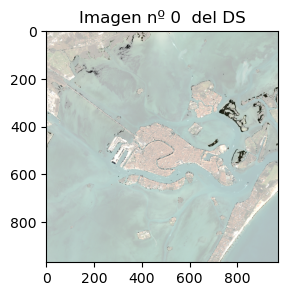

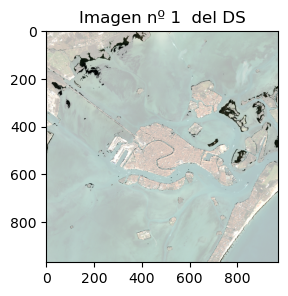

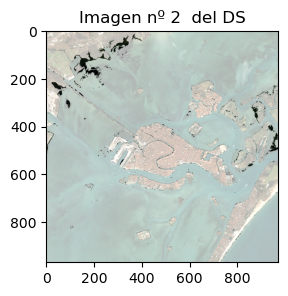

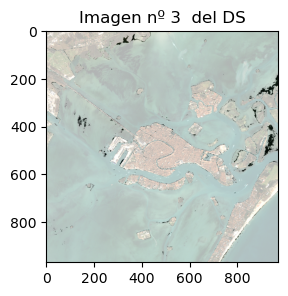

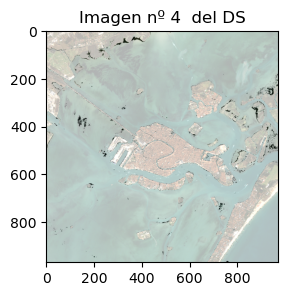

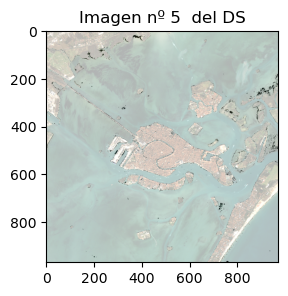

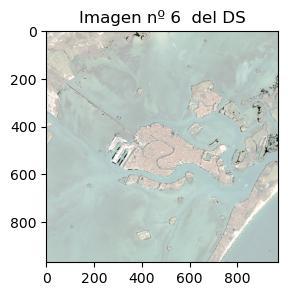

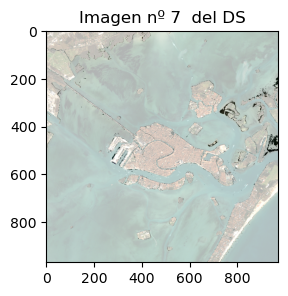

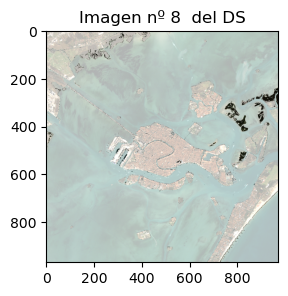

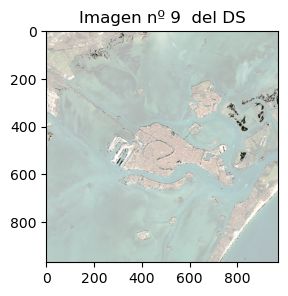

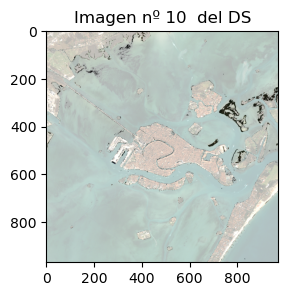

In [731]:
colores = [[0, 0, 0], # Ha habido cambios -> Negro
           [255,255, 255], # se Ha mantenido -> Blanco
          ]
for ind,img in enumerate(ls_maps_inund):
    i_densi2 = solo_cambios(img,colores)
    fig,ax = plt.subplots(1,1,figsize=(6,3))
    ax.imshow(ls_tc_2[0])
    ax.imshow(i_densi2,cmap='Reds',alpha=0.7)
    ax.set_title(f'Imagen nº {ind}  del DS')

El siguiente código te permite visualizar solos las zonas donde ha habido inundación, mediante el uso de density slicing (función "solo_inundaciones" que muestra las zonas de inunadación en negro).

In [752]:
# Inindaciones
def solo_inundaciones(img,colores):
    res = np.zeros((img.shape[0],img.shape[1],3)).astype(np.uint8)
    res[img == -1 ] = colores[1]
    res[img == 0] = colores[1]
    res[img == 1] = colores[0]
    return res

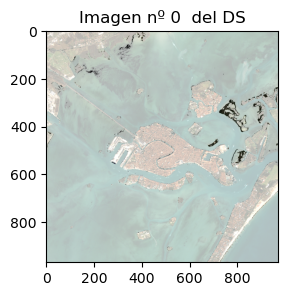

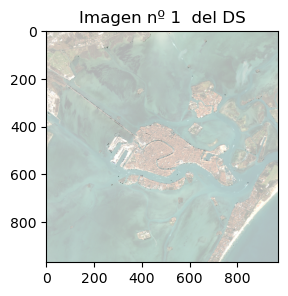

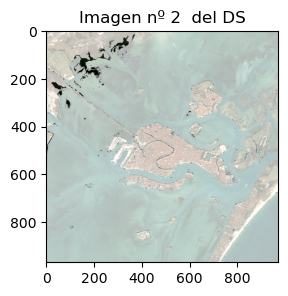

In [753]:
colores = [[0, 0, 0], # Ha habido cambios
           [255,255, 255], # se Ha mantenido
          ]
ls_inund = []
## SOLO SE MUESTRAN LOS 3 PRIMEROS PARA NO LLENAR EL ALMACENAMIENTO
for ind,img in enumerate(ls_maps_inund[:3]):
    i_inund = solo_inundaciones(img,colores)
    ls_inund.append(i_inund)
    fig,ax = plt.subplots(1,1,figsize=(6, 3))
    ax.imshow(ls_tc_2[0])
    ax.imshow(i_inund,cmap='Reds',alpha=0.7)
    ax.set_title(f'Imagen nº {ind}  del DS')

## Paso 5, ¿Donde se inunda más?, ¿Cuando se inunda más?

Durante el periodo de otoño es cuando más se inunda Venecia, por lo tanto durante ese periodo de tiempo, se quiere ver las zonas donde
más inundaciones ocurren. 
Para ello se escoge los pixeles que aparecen con más frecuencia a 1 (Inundación) y vamos a verlo reflejado sobre el mapa.

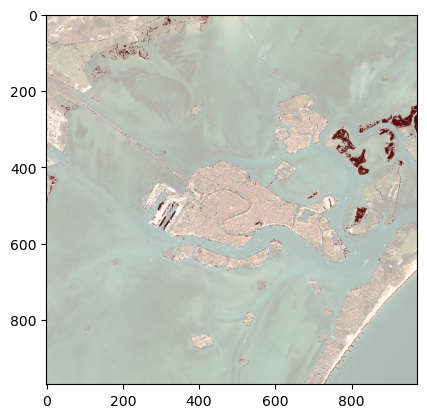

In [757]:
#Creamos un mapa de frecuencia con los valores iniciales a 0 
mapa_frec = np.zeros_like(ls_maps_inund[0], dtype=np.uint8)
res = 0
for im in ls_maps_inund[8:10]:
    # sumamos con que frecuencia parece 1 "se inunda" en cada zona para cada mapa
    mapa_frec += (im == 1).astype(np.uint8) 
# Calculamos el  valor de frecuencia de inundación maximo
max_frec = np.max(mapa_frec)
# zacamos donde se da esas maxima frecuencia de inundación
zonas_frec = mapa_frec == max_frec
fig,ax = plt.subplots(1,1)
ax.imshow(ls_tc_2[0])
ax.imshow(zonas_frec,cmap='Reds',alpha=0.7)

A continuación se representa una gráfica, donde se muestra la cantidad de  pixeles inundados 
para cada intervalo de meses.

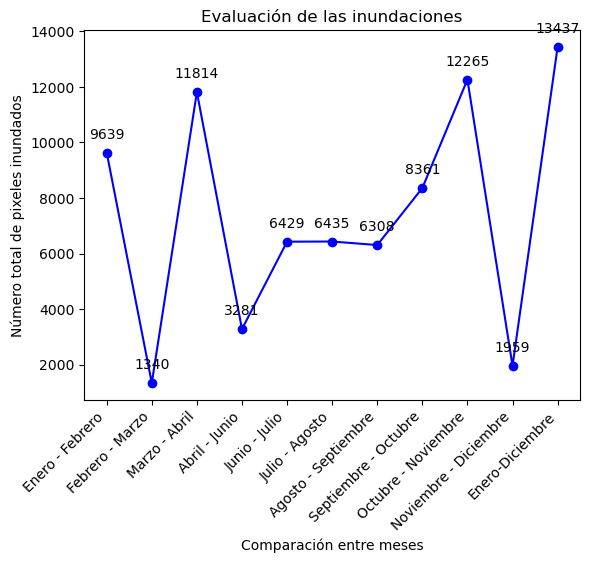

In [751]:
conteo_inun = []
for im in ls_maps_inund:
    # sumamos el total de inundaciones que ha habido en cada mapa 
    # lo añadimos a una lista 
    mapa_cont = np.sum(im == 1)
    conteo_inun.append(mapa_cont)
# Obtenemos la cantidad de intervalos contados 
comparaciones = np.arange(len(conteo_inun))
# Visualizamos la gráfica 
fig, ax = plt.subplots(1, 1)
# Visualizamos las distintas comparaciones y la cantidad de inundaciones que ha habio
ax.plot(comparaciones, conteo_inun, marker='o', linestyle='-', color='blue')
ax.set_xticks(comparaciones)
# Establecemos como etiquetas del eje x los intervalos
ax.set_xticklabels(ls_meses_inter, rotation=45, ha='right')
# Esta parte para Asiganar etiquetas numéricas a cada punto
for i,y in enumerate(conteo_inun, ):
        ax.annotate(y, (comparaciones[i], conteo_inun[i]),textcoords="offset points",xytext=(0,10), ha='center') 
ax.set_title('Evolución de las inundaciones')
ax.set_xlabel('Comparación entre meses')
ax.set_ylabel('Número total de pixeles inundados')
plt.show()

- Durante, el periodo octubre - Noviembre (Otoño) es cuando más inundaciones ha habido. 
- La diferencia del primer mes con el ultimo es enorme.

## Paso 5 K-Means VS Density slicing

A continuación se quiere ver como sería el proceso si se aplica K-Means en lugar Density slicing.
- Para ello, mediante la función aplica_kmeans_Inunda, se aplica el algoritmo de K-mean para segmentar. En este algoritmo en los centroides de los clústeres es donde se tienen
los valores más altos de NDWI (donde hay agua), por lo tanto segmentamos el mapa en función de donde se alcanzan estos valores.

In [760]:
def aplica_kmeans_Inunda(img,n_clusters=2):
    # Hacemos el flateneado de la imagen para el agoritmo
    flat = img.reshape(-1, 1)
    f,c = img.shape
    kmeans = KMeans(
        n_clusters=n_clusters,
        max_iter=100,
        n_init=1,
        random_state=1,
    ).fit(flat)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    # sacamos los centroides, que son los valores promedio de NWDI para cada gurupo
    # NWDI, tiene valores más alto para el agua que para la tierra
    centr = kmeans.cluster_centers_
    id_agua = np.argmax(centr)
    img_res = kmeans.labels_.reshape(f, c)
    # cramos un mapa binario donde  haya un 1 donde hay agua y un 0 donde no hay agua
    mapa_agua_Kmeans = (img_res == id_agua).astype(np.int8)
    return mapa_agua_Kmeans

Se muestran las imágenes resultantes de aplicar K-Means

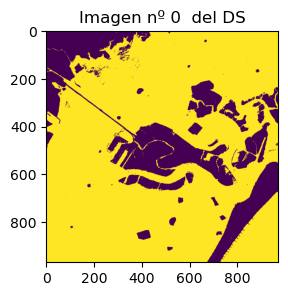

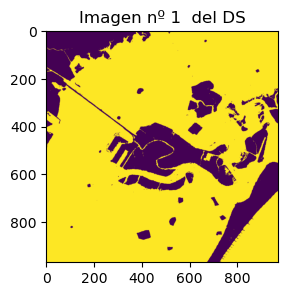

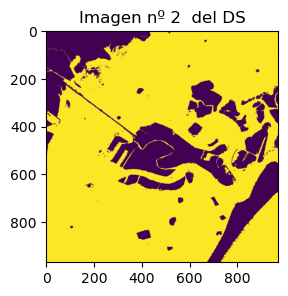

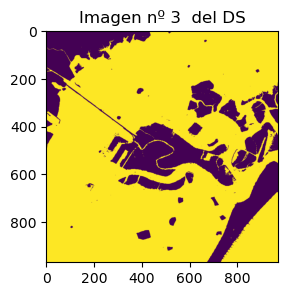

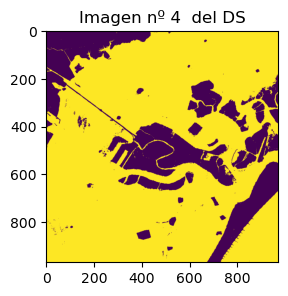

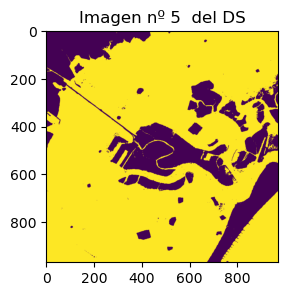

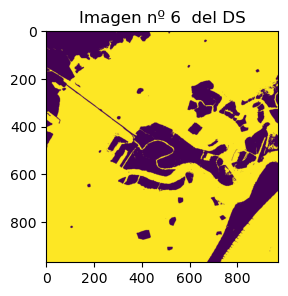

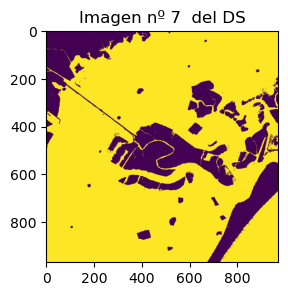

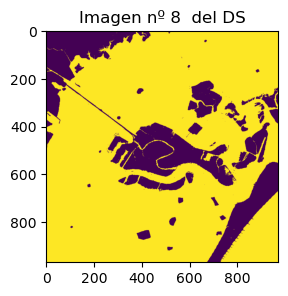

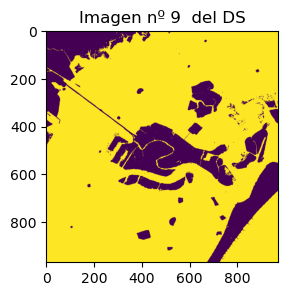

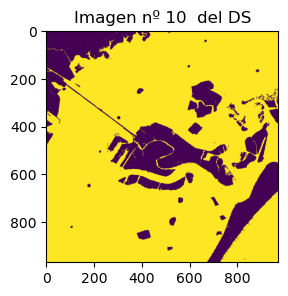

In [761]:
ls_map_kmean = []
for ind,img in enumerate(ls_ndwi):
    i_kmean = aplica_kmeans_Inunda(img)
    ls_map_kmean.append(i_kmean)
    fig,ax = plt.subplots(1,1,figsize=(6, 3))
    ax.imshow(i_kmean)
    ax.set_title(f'Imagen nº {ind}  del DS')

Se usa la misma función "mapa_diferencia" pero con una ligera diferencia:
- **K-means** tal como se ha programado ya te devuelve el mapa binario, por lo tanto no es necesario esa conversión que se aplica con density slicing.

In [746]:
def mapa_diferencia_kmeans(ls):
    ls_mapa = []
    for i in range(len(ls)-1):
        # Se acceden a los valores binarios directamente.
        mapa_marea1 = ls[i]
        mapa_marea2 = ls[i+1]
        # Se aplica la resta
        mapa_inundacion = mapa_marea2 - mapa_marea1
        ls_mapa.append(mapa_inundacion)
    # Por ultimo comparamos el primero con el ultimo 
    mapa_marea1 =ls[0]
    mapa_marea2 = ls[-1]
    mapa_inundacion = mapa_marea2 - mapa_marea1
    ls_mapa.append(mapa_inundacion)
    return ls_mapa

In [747]:
ls_maps_inund_km = mapa_diferencia_kmeans(ls_map_kmean)

In [ ]:
Se muestra a continuación los mapas de inundaciones resultantes tras aplicar K-Means y tras aplicar density slicing, para contrastarlos.

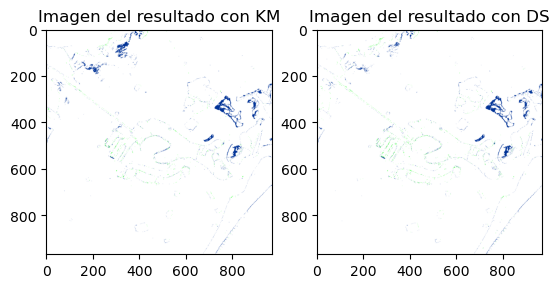

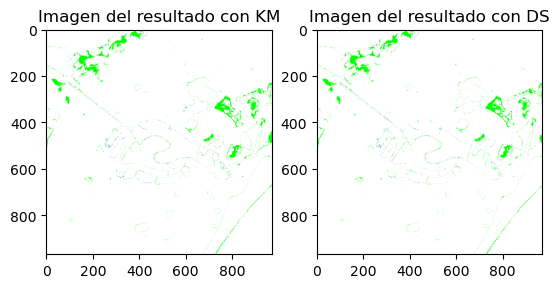

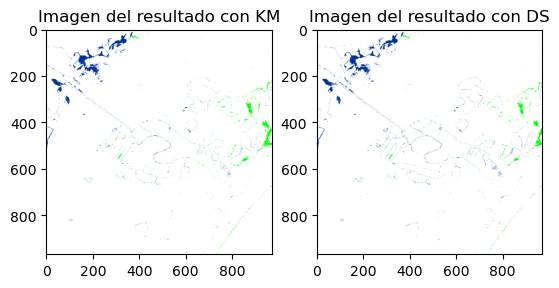

In [748]:
colores = [[0, 255, 0], # Se ha retirado el agua en azul
           [255,255, 255], # se Ha mantenido
           [0, 50, 150] # Innundación en naranja 
          ]
ls_densi2_km = []
for ind,(imgk,imgds) in enumerate(zip(ls_maps_inund_km, ls_densi2DS)):
    i_densi2 = densi2(imgk,colores)
    ls_densi2_km.append(i_densi2)
    if(ind<3):
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(i_densi2)
        ax[0].set_title(f'Imagen del resultado con KM')
        ax[1].imshow(imgds)
        ax[1].set_title(f'Imagen del resultado con DS')

Ambas técnicas obtienen resultados idénticos .

## Conclusiones

El análisis ha tenido estas carencias:
- Un conjunto de imágenes más grande y una moro frecuencia de imágenes (3 Imágenes por mes) para estudiar con mayor precisión las inundaciones.

Corrección de las imágenes con nubes, se podría haber hecho con:
- Composición de imágenes multiespectrales, combinando pixeles de la imagen afectada con pixeles de la imagen limpia.
- Herramientas de IA, hay software de IA que permiten rellenar las zonas afectadas.
-  Sistemas de Información Geográfica (SIG) que permiten aplicar correcciones a las imágenes.

No obstante, se ha logrado:
- Servir de base para un estudio más preciso de inundaciones.
- Ver que el NDWI se puede aplicar en el estudio de inundaciones.
- Corroborar teorías como que los meses de otoño es cuando más se inunda en Venecia.
- Ver que si se aplica Density slicing con un buen umbral se pueden obtener resultados similares  k-means (aunque este es más preciso y más rápido de hacer).